# Машинное обучение, DS-поток, осень 2024
## Задание ML.11


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **190 баллов**  

Всего &mdash; **190 баллов**  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms
import torchvision

import wandb
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

from torchvision.io import decode_image
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import f1_score

In [2]:
sns.set(style='darkgrid', palette='Set2')
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# Bot check

# HW_ID: ds_ml11
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### 0. Инструкция Pytorch Lightning + WandB

Это задание нужно выполнять, используя Pytorch Lightning совместно с WandB.

1. Обучение каждой из моделей должно идти с отдельным запуском в WandB. Если вы закончили всю работу с данной моделью (включая тестирование), не забывайте завершать запуск с помощью `wandb.finish()`.


2. **Важно**: Делать скрины с [wandb.ai](https://wandb.ai) и вставлять ссылки на [wandb.ai](https://wandb.ai) крайне не приветствуется и может караться. Не создавайте ссылок на ваш проект &mdash; он должен быть приватным! Вместо этого, смотрите пункт [Визуализация запусков и выводы](#vis).

3. Если вы сделали задание только частично, все равно визуализируйте имеющиеся запуски в пункте [Визуализация запусков и выводы](#vis).



## Задача 1. Transfer learning
Вы научите нейронную сеть классифицировать произведения искусства различных художников, т.е. определять к какому художнику относится картина.

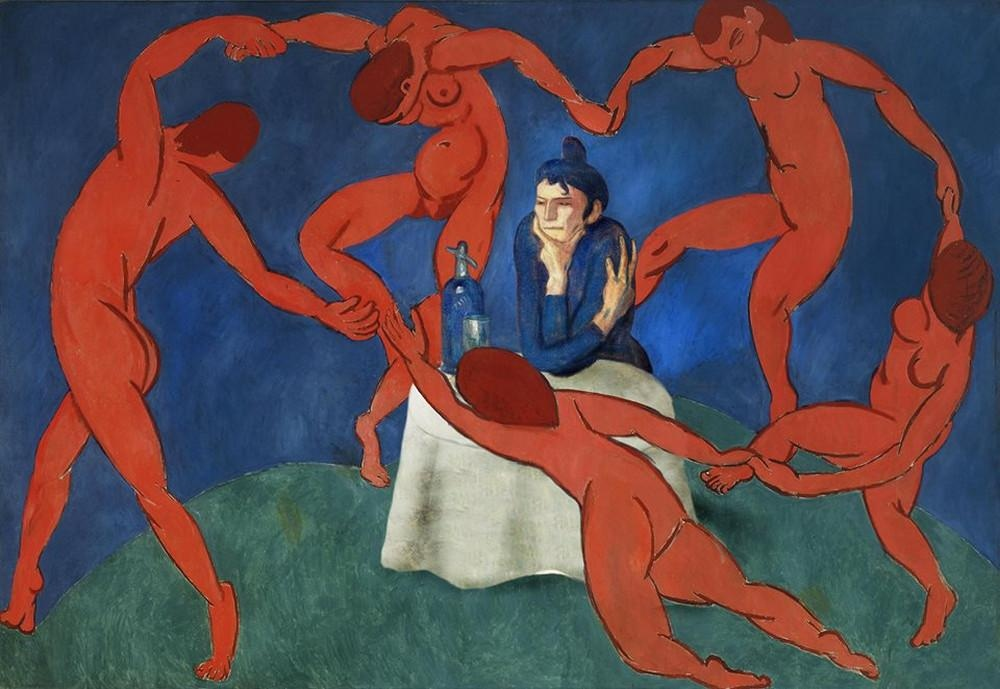

### 1. Данные
Скачайте архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

Если вы работаете в **Google Colab**, то удобнее всего будет скачать архив на Google Drive (диск). В таком случае не придестя загружать архив вручную каждый раз, когда обрывается runtime. Для этого перейдите в левую  боковую панель, нажмите на кнопку с папочкой, а затем на кнопку с папочкой с изображением Google Drive. Теперь все файлы с диска доступны по пути `drive/MyDrive/`.

Если вы работаете в **Kaggle**, то для того, чтобы загрузить данные, перейдите в правую боковую панель. В разделе `Data` возле кнопки `Add Data` расположена кнопка загрузки данных. Нажмите на нее, появится панель `Create a New Dataset`. Назовите новый датасет. Загрузите туда архив.  После того, как датасет будет проверен, он повится у вас в датасетах. Для того, чтобы начать с ним работать в ноутбуке в Kaggle нужно снова перейти в раздел `Data` и нажать `Add Data`. Затем нажмите кнопку `Your Datasets` и нажмите на плюс возле вашего датасета. После этго датасет появится в а разделе `Data`. Причем **Kaggle** разархивирует данные за вас.

Для того, чтобы разархивировать данные, выполните следующие действия.

In [4]:
kaggle_flag = True

data_path = " "
if kaggle_flag:
    data_path = Path("/kaggle/input/artworks1/artworks")
else:
    data_path = Path('artworks1')

Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [5]:
sorted((data_path / 'images' / 'train').iterdir())

[PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Alfred_Sisley'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Amedeo_Modigliani'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Andrei_Rublev'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Andy_Warhol'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Camille_Pissarro'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Caravaggio'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Claude_Monet'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Diego_Rivera'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Diego_Velazquez'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Edgar_Degas'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Edouard_Manet'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Edvard_Munch'),
 PosixPath('/kaggle/input

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [6]:
sorted((data_path / 'images' / 'train' / 'Albrecht_Durer').iterdir())

[PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_001.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_002.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_004.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_005.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_006.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_007.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_008.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_010.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_011.jpg'),
 PosixPath('/kaggle/input/artworks1/artworks/images/train/Albrecht_Durer/Albrecht_Durer_012.jpg'),
 PosixPath

Приведем примеры изображений.

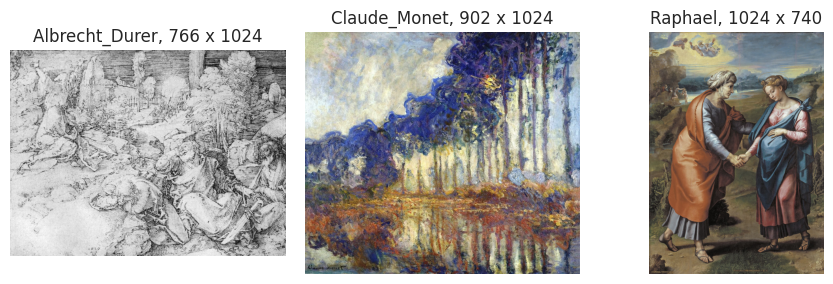

In [7]:
images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg'
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Заметьте, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации, см. пример с Симпсонами в семинаре.

Теперь посмотрим на таблицу с характеристиками художников.

In [8]:
artists_df = pd.read_csv(data_path / 'artists.csv')
artists_df.head(10)

,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого худодника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

In [9]:
truncated_artists_df = artists_df[artists_df['paintings'] >= 200].copy()
truncated_artists_df["name"] = truncated_artists_df["name"].str.replace(" ", "_")
truncated_artists_df.head(10)

,name,years,genre,nationality,bio,wikipedia,paintings
8,Vincent_van_Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
13,Pablo_Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,Pierre-Auguste_Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
16,Francisco_Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
19,Albrecht_Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
20,Alfred_Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
22,Marc_Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
30,Edgar_Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


In [10]:
truncated_artists_df.shape

(11, 7)

In [11]:
artists_df.shape

(50, 7)

Создадим дополнительную директорию, куда выгрузим художников с не менее чем 200 картинами.

In [12]:
trunc_train_dir = data_path / "images" / "filtered_train" 
trunc_val_dir = data_path / "images" / "filtered_val"

Для обучения вам понадобится построить датасет. Удобнее всего будет воспользоваться `torchvision.datasets.ImageFolder`, см. пример в семинаре с Симпсонами.

In [13]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dataset = torchvision.datasets.ImageFolder(
    trunc_train_dir,
    transform=train_transform,
)

val_dataset = torchvision.datasets.ImageFolder(
    trunc_val_dir,
    transform=val_transform,
)

### 2. Fine-tuning
Выберите одну из моделей [здесь](https://pytorch.org/vision/stable/models.html) для fine-tuning, архитектуру которой мы разбирали на лекции. Поясните свой выбор.

**Ответ:** Возьмем модель ResNet. Она не является слишком тяжелой, обладает неплохой точностью, и хорошо себя показала в соревнованиях.

Как вы думаете, какой вариант fine-tuning больше подходит для данной задачи?

**Ответ:** У нас достаточно большой датасет, поэтому разумно разморозить только какую то часть верхних слоев, в предположении, что простые признаки у нас совпадут с теми, что заложены в модели.

Создадим класс модели для Pytorch Lightning:

In [14]:
class FineTunedResNet(LightningModule):
    def __init__(self, n_classes=39, lr=0.01, device='cuda', unfreeze_layers=0):
        '''Инициализация модели'''
        super().__init__()

        self.n_classes = n_classes
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.unfreeze_layers = unfreeze_layers  # Параметр для указания количества размороженных слоев
        self.save_hyperparameters()

        # Загружаем предобученную ResNet50
        backbone = resnet50(weights='ResNet50_Weights.DEFAULT')
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]  # Убираем последний классификатор
        self.feature_extractor = nn.Sequential(*layers)

        # Размораживаем слои по количеству, указанному в unfreeze_layers
        total_layers = len(self.feature_extractor)
        for i, layer in enumerate(self.feature_extractor):
            if i < total_layers - self.unfreeze_layers:
                # Замораживаем слои
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                # Размораживаем слои
                for param in layer.parameters():
                    param.requires_grad = True

        # Добавляем классификатор
        self.classifier = nn.Sequential()
        self.classifier.add_module('relu_1', nn.ReLU())
        self.classifier.add_module('fc_1', nn.Linear(num_filters, 512))
        self.classifier.add_module('relu_2', nn.ReLU())
        self.classifier.add_module('fc_2', nn.Linear(512, self.n_classes))

    def forward(self, x):
        '''Forward pass'''
        representations = self.feature_extractor(x).flatten(1)
        out = self.classifier(representations)
        return out

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, f1 = self.__get_preds_loss_f1(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_f1', f1)

        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, f1_sc = self.__get_preds_loss_f1(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_f1', f1_sc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def __get_preds_loss_f1(self, batch):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        
        # Переводим тензоры на CPU для вычисления f1-score
        preds_cpu = preds.cpu().numpy()
        y_cpu = y.cpu().numpy()
        
        # Вычисляем f1-score с учетом zero_division
        f1 = f1_score(y_cpu, preds_cpu, average='macro', labels=list(range(self.n_classes)), zero_division=0)
        
        return preds, loss, f1

    def test_step(self, batch, batch_idx):
        '''Шаг тестирования для логирования F1 Score на редких классах'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        # Инициализируем списки, если они еще не созданы
        if not hasattr(self, "test_preds"):
            self.test_preds = []
            self.test_targets = []

        # Сохраняем предсказания и целевые метки
        self.test_preds.append(preds.cpu())
        self.test_targets.append(y.cpu())

        return {"preds": preds, "targets": y}

    def on_test_epoch_end(self):
        '''Выполняется в конце тестовой эпохи для подсчета F1 Score'''
        # Объединяем все предсказания и метки в один массив
        all_preds = torch.cat(self.test_preds, dim=0).numpy()
        all_targets = torch.cat(self.test_targets, dim=0).numpy()

        # Вычисляем F1 Score для всех классов
        f1_per_class = f1_score(
            all_targets, all_preds, average=None, labels=range(self.n_classes), zero_division=0
        )

        # Логируем F1 Score для редких классов
        rare_classes = [i for i, count in enumerate(np.bincount(all_targets)) if count < 20]  # Классы с малым количеством наблюдений
        rare_f1 = f1_score(
            all_targets, all_preds, labels=rare_classes, average="macro", zero_division=0
        )
        self.log('rare_f1', rare_f1, prog_bar=True)

        # Логируем F1 Score для каждого класса
        for i, f1 in enumerate(f1_per_class):
            self.log(f'f1_class_{i}', f1)

        # Вычисляем общий взвешенный F1 Score
        overall_f1 = f1_score(all_targets, all_preds, average="weighted", zero_division=0)
        self.log('test_f1_score', overall_f1, prog_bar=True)

        # Очищаем списки для следующего запуска теста
        self.test_preds.clear()
        self.test_targets.clear()

In [15]:
class LogPredictionsCallback(Callback):
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        '''Вызывается после валидационного батча.
        `outputs` приходит из `LightningModule.validation_step`,
        что в данном случае соответствует предсказаниям модели'''

        # Будем логировать предсказания для 20 картинок из первого батча
        if batch_idx == 1:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Вариант 1: логируем картинки
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)

            # Вариант 2: логируем предсказания как таблицу
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(key='sample_table', columns=columns, data=data)

In [16]:
batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [17]:
# Создаем итератор для DataLoader
data_iter = iter(training_loader)

# Получаем следующий батч данных
batch_example = next(data_iter)

In [18]:
batch_example[1]

tensor([7, 4, 6, 2, 1, 8, 9, 9, 2, 3, 3, 5, 8, 3, 5, 7, 4, 5, 7, 9, 9, 1, 1, 1,
        7, 6, 4, 0, 9, 7, 8, 2, 7, 5, 9, 1, 0, 4, 2, 6, 2, 9, 9, 9, 7, 9, 1, 3,
        1, 1, 9, 4, 4, 1, 6, 3, 5, 9, 4, 5, 2, 4, 0, 7])

Попробуйте fine-tuning с разным количеством размороженных слоев, достаточно трех вариантов. Сравните ошибку (лосс) и качество (F1 macro) на тренировочной и тестовой частях выборки во время обучения. F1 Score считайте не на каждом батче, а на всей эпохе. Для этого можно воспользоваться методами `on_train_epoch_end` и `on_validation_epoch_end`.

In [19]:
device = "cuda"

first_fine_tuned_model = FineTunedResNet(
    n_classes=truncated_artists_df.shape[0], lr=0.01, device=device, unfreeze_layers=5
)

second_fine_tuned_model = FineTunedResNet(
    n_classes=truncated_artists_df.shape[0], lr=0.01, device=device, unfreeze_layers=20
)

third_fine_tuned_model = FineTunedResNet(
    n_classes=truncated_artists_df.shape[0], lr=0.01, device=device, unfreeze_layers=40
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


In [20]:
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

# текущий запуск логируется в проекте "image_classification"
wandb_logger = WandbLogger(project='image_classification', log_model='all')

log_predictions_callback = LogPredictionsCallback()

Обучим первую модель

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu"

first_trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback],
    accelerator=device,                      # используем GPU
    max_epochs=20)

In [22]:
first_trainer.fit(first_fine_tuned_model, training_loader, validation_loader)

torch.save(first_fine_tuned_model.state_dict(), 'first_fine_tuned_model.pth')
wandb.finish()

wandb: Currently logged in as: demoren (demoren_mipt). Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_f1,▁▁▁▂▄▄▅▇▆▆▇██▇███
train_loss,██▇▆▅▄▄▃▃▃▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_f1,▁▁▁▁▂▄▅▆▆▇▇▇████████
val_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,19
train_f1,0.87876
train_loss,0.12812
trainer/global_step,879
val_f1,0.11666


In [23]:
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor="val_f1", mode="max")

# текущий запуск логируется в проекте "image_classification"
wandb_logger = WandbLogger(project="image_classification", log_model="all")

log_predictions_callback = LogPredictionsCallback()

second_trainer = Trainer(
    logger=wandb_logger,  # логгер из WandB
    callbacks=[
        log_predictions_callback],
    accelerator=device,  # используем GPU
    max_epochs=20,
)

second_trainer.fit(second_fine_tuned_model, training_loader, validation_loader)

torch.save(second_fine_tuned_model.state_dict(), "second_fine_tuned_model.pth")
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_f1,▁▁▁▁▃▄▅▅▇█▇▇▇▆███
train_loss,██▇▆▅▅▄▃▂▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
val_f1,▁▁▁▂▂▄▅▆▆▇▇▇████████
val_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,19
train_f1,0.84435
train_loss,0.25784
trainer/global_step,879
val_f1,0.11699


In [24]:
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor="val_f1", mode="max")

# текущий запуск логируется в проекте "image_classification"
wandb_logger = WandbLogger(project="image_classification", log_model="all")

log_predictions_callback = LogPredictionsCallback()

third_trainer = Trainer(
    logger=wandb_logger,  # логгер из WandB
    callbacks=[
        log_predictions_callback],
    accelerator=device,  # используем GPU
    max_epochs=20,
)

third_trainer.fit(third_fine_tuned_model, training_loader, validation_loader)

torch.save(third_fine_tuned_model.state_dict(), "third_fine_tuned_model.pth")
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_f1,▁▁▁▁▃▅▅▆▆▇▇█▇████
train_loss,█▇▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
val_f1,▁▁▁▁▂▄▅▆▆▇▇▇████████
val_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,19
train_f1,0.82654
train_loss,0.23244
trainer/global_step,879
val_f1,0.11456


Поясните, в чем преимущества F1 macro по сравнению с accuracy. Сделайте выводы.

F1 score лучше справляется в случаях с несбалансированными классами, что присутствует в нашем случае. Также accuracy не различает ложные срабатывания (False Positives, FP) и пропуски (False Negatives, FN).

**Вывод:**

В задаче была рассмотрена модель resnet50 с разным уровнем размороженных слоев. Было получено, что в нашей оптимальным

### 3. Аугментации

Для улучшения качества модели можно расширить обучающую выборку. Это можно сделать с помощью аугментации данных. Подумайте, какие аугментации здесь будут полезны, напишите свой ответ.

**Ответ:**  Нет смысла поворачивать картины и менять цветовую гамму, так как это уже заложено в стиле художника. Самым оптимальным кажется симметрия относительно оси y, так мы сможем сохранить стиль, и показать его модели.

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [25]:
input_size = 200

train_dir = data_path / "images" / "filtered_train" 
val_dir = data_path / "images" / "filtered_val"

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.RandomHorizontalFlip(p=0.5), # С вероятностью 50% отражаем изображение по горизонтали
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform,
)

val_dataset = torchvision.datasets.ImageFolder(
    val_dir,
    transform=val_transform,
)

batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

Выберите лучшую модель. Примените fine-tining модели
 на аугментированных данных. Получается ли улучшить качество?

In [26]:
best_model = FineTunedResNet(
    n_classes=truncated_artists_df.shape[0], lr=0.01, device=device, unfreeze_layers=10
)

# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

# текущий запуск логируется в проекте "image_classification"
wandb_logger = WandbLogger(project='image_classification', log_model='all')

log_predictions_callback = LogPredictionsCallback()

best_trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback],       # и сам чекпоинтер
    accelerator=device,                      # используем GPU
    max_epochs=20)

In [27]:
best_trainer.fit(best_model, training_loader, validation_loader)

torch.save(best_model.state_dict(), 'best_model.pth')
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_f1,▁▁▁▁▃▄▅▆▆▇▆▆▆▇▇▇█
train_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
val_f1,▁▁▁▁▃▄▅▆▇▇▇▇▇███████
val_loss,█▇▇▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,19
train_f1,0.90909
train_loss,0.14856
trainer/global_step,879
val_f1,0.11776


**Вывод:**

Аугментация данных не значительно улучшило качество нашей модели. Кажется на данных подобным нашим, аугментация не может сильно улучшить качество, так как картина является в своем изначальном виде является чем-то неизменным, то есть повроты, растяжения или изменение цвета наоборот испортят данные, чем дадут новые.

### 4. Несбалансированность классов
Расширим выборку до всех классов. Примените fine-tuning для расширенной выборки. Хорошо ли модель предсказывает малопредставленные классы?

Для подсчета F1 Score на редких классах после обучения определите у модели метод `test_step` и запустите `trainer.test(model, ...)` (до завершения запуска WandB!). На тесте разрешается записывать метки / предсказания в поля класса.

In [28]:
input_size = 200

train_dir = data_path / "images" / "train" 
val_dir = data_path / "images" / "test"

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

# Трансформация для валидации
val_transform = transforms.Compose([
    transforms.Resize(input_size),         # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),     # Вырезаем из центра квадрат размера input_size x input_size
    transforms.ToTensor(),                 # Приводим к тензору
])

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform,
)

val_dataset = torchvision.datasets.ImageFolder(
    val_dir,
    transform=val_transform,
)

batch_size = 64

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [29]:
test_model = FineTunedResNet(
    n_classes=artists_df.shape[0], lr=0.01, device=device, unfreeze_layers=10
)

# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_f1', mode='max')

# текущий запуск логируется в проекте "image_classification"
wandb_logger = WandbLogger(project='image_classification', log_model='all')

log_predictions_callback = LogPredictionsCallback()

test_trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback],
    accelerator=device,                      # используем GPU
    max_epochs=20)

In [30]:
test_trainer.fit(test_model, training_loader, validation_loader)

test_trainer.test(test_model, dataloaders=validation_loader)

torch.save(test_model.state_dict(), 'test_model.pth')
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        f1_class_0         │    0.8653846383094788     │
│        f1_class_1         │    0.7251461744308472     │
│        f1_class_10        │    0.7946428656578064     │
│        f1_class_11        │    0.27450981736183167    │
│        f1_class_12        │    0.1428571492433548     │
│        f1_class_13        │    0.7017543911933899     │
│        f1_class_14        │            0.0            │
│        f1_class_15        │    0.6341463327407837     │
│        f1_class_16        │    0.6153846383094788     │
│        f1_class_17        │           0.375           │
│        f1_class_18        │    0.8235294222831726     │
│        f1_class_19        │          0.5625           │
│        f1_class_2         │    0.8455284833908081     │
│        f1_class_20        │            0.0            │
│        f1_class_21        │    0.6724137663841248     │
│        f1_class_22        │           0.75            │
│        f1_class_23        │    0.17142857611179352    │
│        f1_class_24        │     0.717391312122345     │
│        f1_class_25        │            0.0            │
│        f1_class_26        │    0.4878048896789551     │
│        f1_class_27        │    0.5555555820465088     │
│        f1_class_28        │    0.5396825671195984     │
│        f1_class_29        │    0.5681818127632141     │
│        f1_class_3         │    0.8253968358039856     │
│        f1_class_30        │    0.7083333134651184     │
│        f1_class_31        │            0.5            │
│        f1_class_32        │    0.4237288236618042     │
│        f1_class_33        │    0.5567765831947327     │
│        f1_class_34        │            0.0            │
│        f1_class_35        │    0.6892655491828918     │
│        f1_class_36        │    0.6611570119857788     │
│        f1_class_37        │     0.54347825050354      │
│        f1_class_38        │     0.807692289352417     │
│        f1_class_39        │    0.3589743673801422     │
│        f1_class_4         │    0.8035714030265808     │
│        f1_class_40        │    0.5526315569877625     │
│        f1_class_41        │    0.5762711763381958     │
│        f1_class_42        │    0.7757575511932373     │
│        f1_class_43        │    0.7317073345184326     │
│        f1_class_44        │     0.717391312122345     │
│        f1_class_45        │    0.6504064798355103     │
│        f1_class_46        │    0.5744680762290955     │
│        f1_class_47        │    0.7599999904632568     │
│        f1_class_48        │    0.7824497222900391     │
│        f1_class_49        │    0.5600000023841858     │
│        f1_class_5         │    0.2666666805744171     │
│        f1_class_6         │    0.4285714328289032     │
│        f1_class_7         │    0.1111111119389534     │
│        f1_class_8         │            0.5            │
│        f1_class_9         │    0.3777777850627899     │
│          rare_f1          │    0.18622449040412903    │
│       test_f1_score       │    0.6476500034332275     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
f1_class_0,▁
f1_class_1,▁
f1_class_10,▁
f1_class_11,▁
f1_class_12,▁
f1_class_13,▁
f1_class_14,▁
f1_class_15,▁
f1_class_16,▁
f1_class_17,▁


Как видим f1-score на редких классах оказался в 3 раза ниже, чем на не редких. Это связано с тем, что модель видит слишком мало картин художников с малым количеством картин, а потому и веса у признаков таких картин оказываются малы.

В качестве решения проблемы несбалансированности классов можно взвешивать лосс. Если это [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), то можно указать в параметре `weight` веса классов. Также можно поменять стратегию семплирования при обучении, для этого можно использовать [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) в качестве параметра `sampler` в `dataloader`. Подумайте, как еще можно можно решить эту проблему. Попробуйте одну из стратегий. Получается ли улучшить качество?

In [31]:
number_of_classes = artists_df["paintings"].values
weight_of_classes = torch.tensor(1 / number_of_classes, dtype=torch.float32)

model_with_weights = FineTunedResNet(n_classes=artists_df.shape[0], lr=0.01, unfreeze_layers=10)
model_with_weights.criterion = nn.CrossEntropyLoss(weight=weight_of_classes)

In [32]:
# callback при достижении лучшей точности создает checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='max')

# текущий запуск логируется в проекте "ML_HW_Artists"
wandb_logger = WandbLogger(project='image_classification', log_model='all')

weight_trainer = Trainer(
    logger=wandb_logger,                    # логгер из WandB
    callbacks=[log_predictions_callback],       
    accelerator=device,                      # используем GPU
    max_epochs=20)

weight_trainer.fit(model_with_weights, training_loader, validation_loader)
weight_trainer.test(model_with_weights, dataloaders=validation_loader)

torch.save(model_with_weights.state_dict(), 'model_with_weights.pth')
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        f1_class_0         │     0.782608687877655     │
│        f1_class_1         │     0.717391312122345     │
│        f1_class_10        │    0.7761194109916687     │
│        f1_class_11        │    0.1304347813129425     │
│        f1_class_12        │            0.0            │
│        f1_class_13        │            0.0            │
│        f1_class_14        │            0.0            │
│        f1_class_15        │    0.3965517282485962     │
│        f1_class_16        │   0.054054055362939835    │
│        f1_class_17        │    0.1428571492433548     │
│        f1_class_18        │     0.707317054271698     │
│        f1_class_19        │   0.054054055362939835    │
│        f1_class_2         │    0.8181818127632141     │
│        f1_class_20        │            0.0            │
│        f1_class_21        │    0.6833333373069763     │
│        f1_class_22        │            0.0            │
│        f1_class_23        │    0.2222222238779068     │
│        f1_class_24        │     0.602150559425354     │
│        f1_class_25        │    0.6666666865348816     │
│        f1_class_26        │    0.32258063554763794    │
│        f1_class_27        │    0.5490196347236633     │
│        f1_class_28        │    0.3921568691730499     │
│        f1_class_29        │    0.5192307829856873     │
│        f1_class_3         │    0.8181818127632141     │
│        f1_class_30        │            0.0            │
│        f1_class_31        │            0.0            │
│        f1_class_32        │    0.19672131538391113    │
│        f1_class_33        │    0.4984615445137024     │
│        f1_class_34        │    0.2068965584039688     │
│        f1_class_35        │           0.625           │
│        f1_class_36        │    0.6231883764266968     │
│        f1_class_37        │    0.4590163826942444     │
│        f1_class_38        │    0.7678571343421936     │
│        f1_class_39        │    0.37681159377098083    │
│        f1_class_4         │    0.6168224215507507     │
│        f1_class_40        │     0.557692289352417     │
│        f1_class_41        │    0.5263158082962036     │
│        f1_class_42        │    0.6464646458625793     │
│        f1_class_43        │    0.6944444179534912     │
│        f1_class_44        │    0.6181818246841431     │
│        f1_class_45        │    0.5116279125213623     │
│        f1_class_46        │    0.2222222238779068     │
│        f1_class_47        │    0.6190476417541504     │
│        f1_class_48        │     0.750455379486084     │
│        f1_class_49        │    0.5762711763381958     │
│        f1_class_5         │    0.1538461595773697     │
│        f1_class_6         │    0.27272728085517883    │
│        f1_class_7         │    0.17142857611179352    │
│        f1_class_8         │            0.0            │
│        f1_class_9         │    0.2905983030796051     │
│          rare_f1          │    0.18416394293308258    │
│       test_f1_score       │    0.5243715643882751     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
f1_class_0,▁
f1_class_1,▁
f1_class_10,▁
f1_class_11,▁
f1_class_12,▁
f1_class_13,▁
f1_class_14,▁
f1_class_15,▁
f1_class_16,▁
f1_class_17,▁


К сожалению добавление весов не улучшило качество модели. Зато мы стали лучше распознавать художников с малым количеством картин. Возможно, модель по представленным данным не смогла выделить для себя какие-то важные при признаки, а потому добавление весов не привело к улучшению качества модели

<a name=vis></a>
### 5. Визуализация запусков и выводы

Визуализируйте графики лосса и метрики всех релевантных запусков. Для этого воспользуйтесь `wandb.Api()`, см. семинар. Сравните и сделайте выводы.

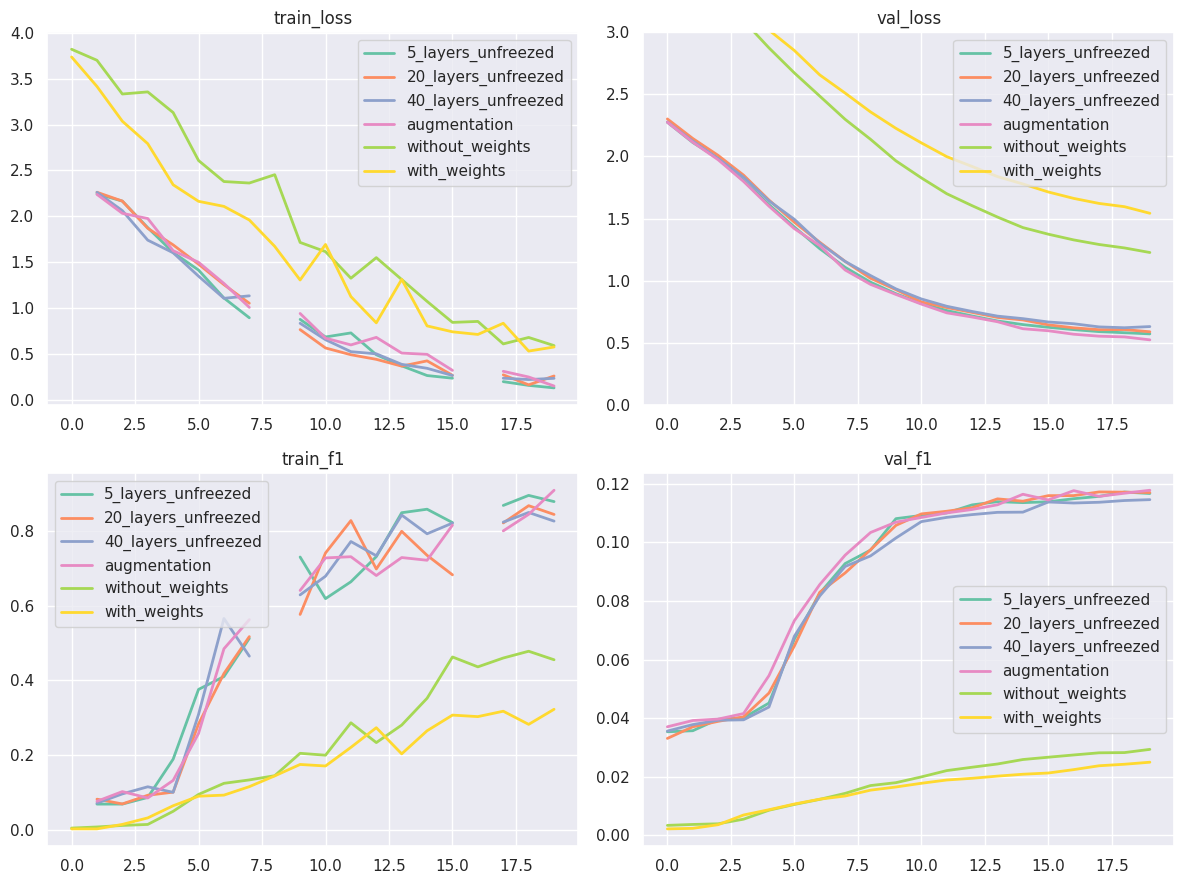

In [34]:
runs = wandb.Api().runs("image_classification")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_f1', 'val_f1']])
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3))
plt.tight_layout()

Сделайте общий вывод по задаче.

**Вывод:**

В работе мы научились использовать предобученные модели. В частности посмотрели на работу fine tuning, аугментации и влияния весов.

В части по fine tuning мы замтели, что количество размороженных слоев никак значительно не повлияло на качество модели.

В части с аугментацией мы добились незначительного роста качества на валидации. Там же было отмечено, что картины не являются хорошим объектом, на котором стоит применять аугментацию, так как нам до мелочей, как выглядит картина, именно это выделяет автора.

В части с несбалансированными весами. Парадоксально, но модель без весов дает лучший f1-score на редких классах, так и в целом, чем модель с весами, которая казалось бы должна была улучшить качество.

При использовании API, wandb почему то потерял несколько эпох, которые есть на самом сайте. Там же видно, что они не представляют большего интереса, так как следуют тренду, заданному на видимом графике.